### __LIBRARIES IMPORTATION__

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import os

import sys
path = "/Users/migue/Documents/F1 Data Center/F1-Data-Center/Programs/Python/"
sys.path.append(path)
import multidata
import gp_txt

### __GENERAL DATA__

In [8]:
year = 2023
grand_prix = 'España'
sesion = "fp1"

path = "/Users/migue/Documents/F1 Data Center/"+str(year)+"/"+grand_prix+"_"+str(year)
os.chdir(path)

#### __STEP 1:__ Data Extraction

In [9]:
sesiones = []
p_sesion = ["fp1.txt","fp2.txt","fp3.txt","quali.txt","race.txt"]
sesIndex = p_sesion.index(sesion+'.txt')

for i in range(len(p_sesion)):
    path = "/Users/migue/Documents/F1 Data Center/"+str(year)+"/"+grand_prix+"_"+str(year)+"/"+p_sesion[i]
    if os.path.exists(path):
        sesiones.append(p_sesion[i])
    else:
        sesiones.append("")

#Generate all data availble from sesiones
datos = gp_txt.gp(sesiones, grand_prix, True)

drivers = datos.lista[sesIndex + len(p_sesion)]
times = datos.definitivo[sesIndex]

#### __STEP 2:__ Preprocessing

In [10]:
def get_sec(lista):
    """Convert x:yy:zzz to miliseconds"""
    sec_list = []
    if len(lista) > 0:
        if lista[0] != 0:
            for i in range(len(lista)):
                suma = 0
                mins = int(lista[i][0:1])*60*1000
                sec = int(lista[i][2:4])*1000
                mil = int(lista[i][5:8])
                suma = mins + sec + mil
                sec_list.append(suma)
        else:
            sec_list.append(0)
    else:
        sec_list.append(0)
        
    return(sec_list)

nptimes = np.empty_like(np.array(times, dtype=object))
for dindex, dtime in enumerate(times):
    nptimes[dindex] = np.array(get_sec(dtime))

In [11]:
def returnQualy_RaceLaps(times: np.array, mode: str = 'tt', minTime = 0):
    qualyLaps = []
    qualyIndeces = []
    raceLaps = []
    raceIndices = []
    minTime = np.nanmin(times)
    if minTime == 0:
        return np.array(np.nan), qualyIndeces, np.array(np.nan), raceIndices
    qualyTop = (minTime * 102)/100
    raceTop = (minTime * 110)/100
    for t,time in enumerate(times):
        if time != np.nan:
            if time <= qualyTop:
                qualyLaps.append(time)
                qualyIndeces.append(t)
            elif time <= raceTop:
                raceLaps.append(time)
                raceIndices.append(t)

    if mode == 'tt': return np.array(qualyLaps), qualyIndeces, np.array(raceLaps), raceIndices
    else: return np.array(qualyLaps), np.array(raceLaps)

#### __STEP 3:__ Plot

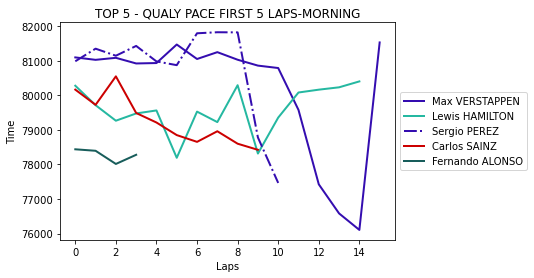

In [12]:
driversRed = ['Max VERSTAPPEN', 'Lewis HAMILTON', 'Sergio PEREZ', 'Carlos SAINZ', 'Fernando ALONSO']
# drivers = dfMorn['Driver'].unique()
colors  = multidata.f1_teams(driversRed, year, 'Default', 'Default').color

alreadyPlot = []
for d,driv in enumerate(driversRed):
    allTimes = nptimes[drivers.index(driv)]
    qualyLaps, raceLaps = returnQualy_RaceLaps(allTimes, mode = 'p')
    if colors[d] not in alreadyPlot:
        plt.plot(raceLaps, linewidth=2 , color = colors[d], label = driv) 
        alreadyPlot.append(colors[d])
    else:
        plt.plot(raceLaps, linewidth=2 , linestyle = 'dashdot', color = colors[d], label = driv) 

ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('TOP 5 - QUALY PACE FIRST 5 LAPS-MORNING') 
plt.xlabel("Laps")
plt.ylabel("Time")
plt.show()

#### __STEP 4:__ Dash

In [7]:
import pandas as pd

# Obtener los tiempos de clasificación de los conductores
colors  = multidata.f1_teams(drivers, year, 'Default', 'Default').color

alreadyPlot = []
dataQualy = []
dataRace = []
for d,driv in enumerate(drivers):
    allTimes = nptimes[d]
    qualyLaps, raceLaps = returnQualy_RaceLaps(allTimes, mode = 'p')
    if colors[d] not in alreadyPlot:
        for indexLap,l in enumerate(qualyLaps):
            dataQualy.append({'Driver': driv, 'Laps': indexLap + 1, 'Time': l, 'Color': colors[d], 'LineDash': None})
        for indexLap,l in enumerate(raceLaps):
            dataRace.append({'Driver': driv, 'Laps': indexLap + 1, 'Time': l, 'Color': colors[d], 'LineDash': None})
    else:
        for indexLap,l in enumerate(qualyLaps):
            dataQualy.append({'Driver': driv, 'Laps': indexLap + 1, 'Time': l, 'Color': colors[d], 'LineDash': 'dashdot'})
        for indexLap,l in enumerate(raceLaps):
            dataRace.append({'Driver': driv, 'Laps': indexLap + 1, 'Time': l, 'Color': colors[d], 'LineDash': 'dashdot'})

dfQualy = pd.DataFrame(dataQualy)
dfRace = pd.DataFrame(dataRace)

print(dfQualy.head())
print(dfRace.head())

           Driver  Laps   Time    Color LineDash
0  Max VERSTAPPEN     1  93375  #340db0     None
1  Logan SARGEANT     1  96507  #1e52b8     None
2  Logan SARGEANT     2  96102  #1e52b8     None
3  Logan SARGEANT     3  96159  #1e52b8     None
4  Logan SARGEANT     4  95749  #1e52b8     None
           Driver  Laps   Time    Color LineDash
0  Max VERSTAPPEN     1  98171  #340db0     None
1  Max VERSTAPPEN     2  98574  #340db0     None
2  Max VERSTAPPEN     3  98474  #340db0     None
3  Max VERSTAPPEN     4  98338  #340db0     None
4  Max VERSTAPPEN     5  98842  #340db0     None


In [ ]:
import plotly.express as px
import pandas as pd
from  dash import dcc, html
from jupyter_dash import JupyterDash


# Crear la aplicación Dash
app = JupyterDash(__name__)

# Crear el gráfico
fig = px.line(df, x="year", y="lifeExp", color='country')

# Configurar el diseño del gráfico
fig.update_layout(title='Life Expectancy in Asia',
                   xaxis_title='Year',
                   yaxis_title='Life Expectancy')

# Crear el diseño de la aplicación Dash
app.layout = html.Div(children=[
    html.H1(children='Line Plot'),
    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server()